# Laboratorio 3 de Inteligencia Artificial: 
## Modelos de clasificación de datasets "winequality-red" y "winequality-white".

### Integrantes grupo 11: 
- FELIPE ANTONIO BARJA CÁRCAMO
- CRISTIAN FELIPE BERNAL SALINAS
- SEBASTIAN ALEJANDRO LILLO ACOSTA
- IGNACIO ANDRÉS VALDEBENITO CÁCERES

##### Librerías necesarias

In [345]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

##### funciones auxiliares

In [ ]:
def add_quality_label(df):
    bins = (2, 5.5, 6.5, 8)
    group_names = ['low-quality', 'average-quality', 'high-quality']
    categories = pd.cut(df['quality'], bins, labels=group_names)
    df['quality_label'] = categories
    return df

## Clasificación para "winequality-red":

### Analisis exploratorio de datos:

In [347]:
red_df = pd.read_csv('winequality-red.csv', delimiter=';')
red_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [387]:
red_df = add_quality_label(red_df)

In [392]:
label_quality = LabelEncoder()

red_df['quality_label'] = label_quality.fit_transform(red_df['quality_label'])

In [352]:
total_samples = len(red_df)
label_counts = red_df['quality_label'].value_counts()
label_proportions = label_counts / total_samples * 100
print(label_proportions)

2    46.529081
0    39.899937
1    13.570982
Name: quality_label, dtype: float64


Distribución de la calidad:

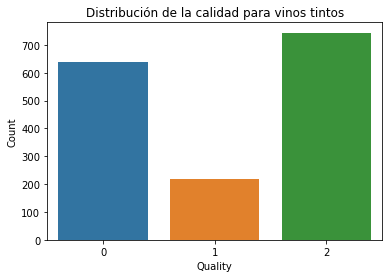

In [353]:
plt.figure(figsize=(6, 4))
sns.countplot(x='quality_label', data=red_df)
plt.title("Distribución de la calidad para vinos tintos")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

Basándonos en la distribución de calidad del dataset "winequality-red", se observa que:

- La categoría de calidad "2" tiene la mayor proporción con un 46.53% de las muestras.
- La categoría de calidad "0" tiene la siguiente proporción más alta con un 39.90% de las muestras.
- La categoría de calidad "1" tiene la proporción más baja con un 13.57% de las muestras.

En general, podemos observar que el dataset de vinos rojos está desequilibrado, ya que hay una diferencia significativa en la cantidad de muestras entre las diferentes categorías de calidad. Esto puede tener un impacto en el rendimiento de los modelos de clasificación, ya que pueden tener dificultades para aprender patrones y predecir con precisión las clases minoritarias.

Para abordar este desequilibrio de clases, se aplicará una técnica de sobremuestreo (oversampling) de las clases minoritarias (categorías "0" y "1") o el submuestreo de la clase mayoritaria (categoría "2"), con el objetivo de equilibrar la distribución de las clases y mejorar el rendimiento del modelo en la clasificación de todas las categorías de calidad.

In [354]:
# Identificar las clases minoritarias
minority_classes = [0, 1]

In [355]:
# Separar las clases minoritarias y mayoritaria
minority_data = red_df[red_df['quality_label'].isin(minority_classes)]
majority_data = red_df[~red_df['quality_label'].isin(minority_classes)]

In [356]:
# Calcular el número de muestras de la clase mayoritaria
n_samples_majority = len(majority_data)

# Generar muestras adicionales para cada clase minoritaria
oversampled_data = pd.concat([
    minority_data[minority_data['quality_label'] == cls].sample(
        n=n_samples_majority, replace=True, random_state=42)
    for cls in minority_classes
])

# Combinar las muestras sobremuestreadas con la clase mayoritaria
oversampled_data = pd.concat([oversampled_data, majority_data])


Mezclar los datos sobremuestreados

In [357]:
oversampled_redwine_df = shuffle(oversampled_data, random_state=42)

In [358]:
total_samples = len(oversampled_redwine_df)
label_counts = oversampled_data['quality_label'].value_counts()
label_proportions = label_counts / total_samples * 100
print(label_proportions)

0    33.333333
1    33.333333
2    33.333333
Name: quality_label, dtype: float64


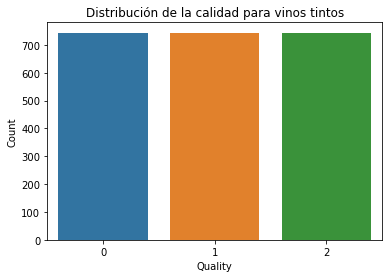

In [359]:
# Distribución de la calidad
plt.figure(figsize=(6, 4))
sns.countplot(x='quality_label', data=oversampled_redwine_df)
plt.title("Distribución de la calidad para vinos tintos")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

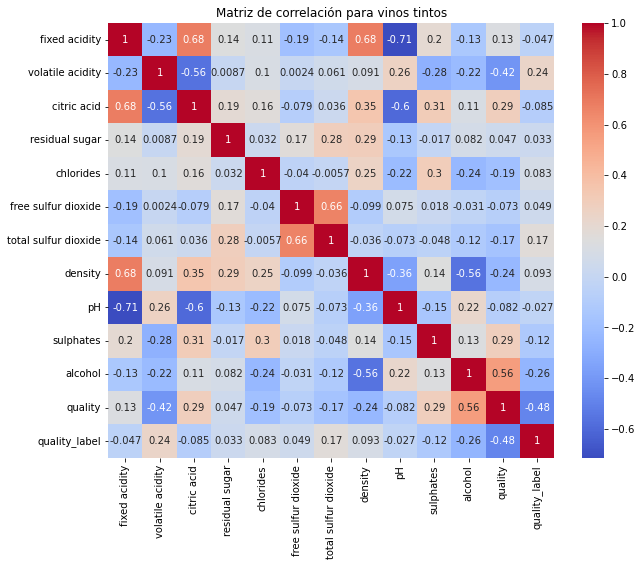

In [360]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
correlation_red = oversampled_redwine_df.corr()
sns.heatmap(correlation_red, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación para vinos tintos")
plt.show()

### Entrenamiento de los modelos de clasificación

Primero, se separan las características de las etiquetas

In [437]:
X_red = oversampled_redwine_df.drop(['quality', 'quality_label'], axis=1)
Y_red = oversampled_redwine_df['quality_label']

Se realiza la división en conjuntos de entrenamiento y prueba

In [371]:
X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_red, Y_red, test_size=0.2, random_state=42)

In [414]:
redwine_svm = SVC(kernel='linear',verbose=False)
redwine_tree = DecisionTreeClassifier()
redwine_forest = RandomForestClassifier()

In [415]:
for model, name in zip([redwine_svm, redwine_tree, redwine_forest], ['SVC', 'Decision Tree', 'Random Forest']):
    for wine, X_train, X_test, Y_train, Y_test in zip(['Red Wine'], [X_red_train], [X_red_test], 
                                                       [y_red_train], 
                                                       [y_red_test]):
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        confusion = confusion_matrix(Y_test, predictions)
        scores = cross_val_score(model, X_test, Y_test, cv=10)
        print(f'{name} model average accuracy on {wine}: {scores.mean()}')
        print(f'Matriz de confusión para {name} en {wine}:\n{confusion}\n')

SVR model average accuracy on Red Wine: 0.5905050505050504
Matriz de confusión para SVR en Red Wine:
[[ 51  40  53]
 [ 54  98   8]
 [ 28   6 109]]

Decision Tree model average accuracy on Red Wine: 0.6803030303030303
Matriz de confusión para Decision Tree en Red Wine:
[[116   7  21]
 [  2 156   2]
 [ 27   5 111]]

Random Forest model average accuracy on Red Wine: 0.7271717171717171
Matriz de confusión para Random Forest en Red Wine:
[[119   7  18]
 [  7 153   0]
 [ 19   2 122]]



En este caso se observan 2 niveles de profundidad para el arbol de decisión que clasifica los vinos tintos.

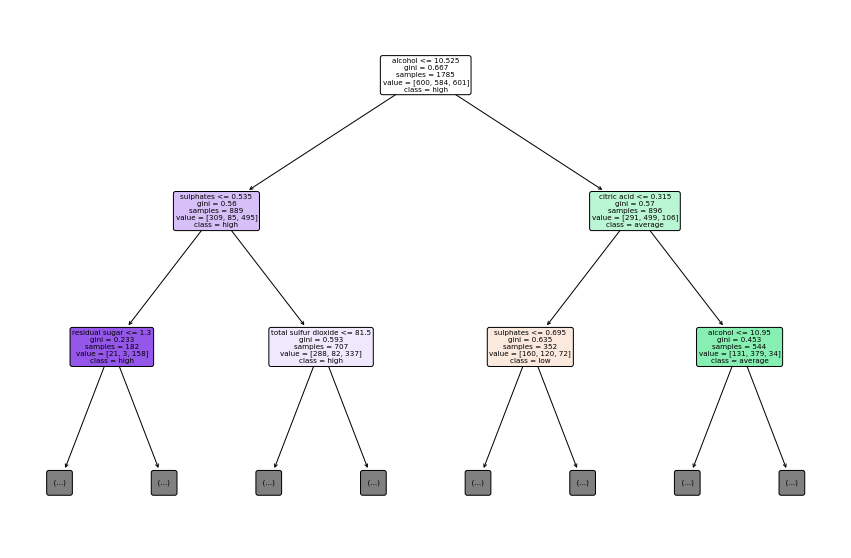

In [427]:
plt.figure(figsize=(15,10))
plot_tree(redwine_tree, 
          filled=True, 
          rounded=True, 
          feature_names=X_red.columns, 
          class_names=['low', 'average', 'high'],
          max_depth=2)

plt.show()

Se visualiza uno de los árboles generados por RandomForest. Aquí se observan los primeros 2 niveles de profundidad. 

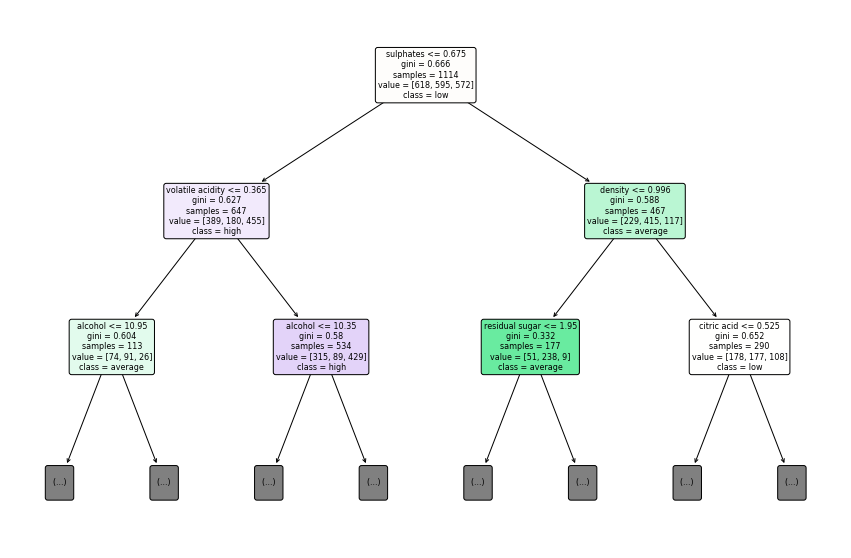

In [428]:
plt.figure(figsize=(15,10))
plot_tree(redwine_forest.estimators_[0], 
          filled=True, 
          rounded=True, 
          feature_names=X_red.columns, 
          class_names=['low', 'average', 'high'],
          max_depth=2)
plt.show()

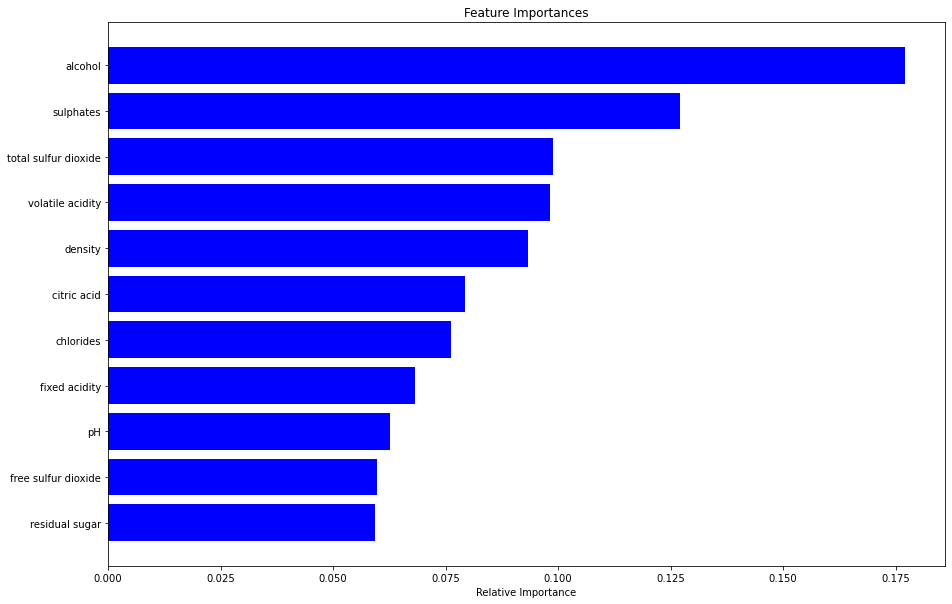

In [430]:
importances = redwine_forest.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(15,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_red.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Clasificación para "winequality-white":

### Análisis exploratorio de datos:

In [389]:
white_df = pd.read_csv('winequality-white.csv',delimiter=';')
white_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [390]:
white_df = add_quality_label(white_df)

In [393]:
label_quality = LabelEncoder()

white_df['quality_label'] = label_quality.fit_transform(white_df['quality_label'])

In [394]:
white_df = white_df[white_df['quality_label'] != 3]

In [395]:
total_samples = len(white_df)
label_counts = white_df['quality_label'].value_counts()
label_proportions = label_counts / total_samples * 100
print(label_proportions)

0    44.921316
2    33.517270
1    21.561414
Name: quality_label, dtype: float64


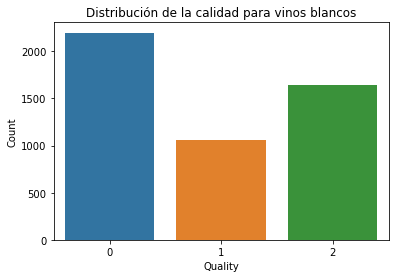

In [396]:
# Distribución de la calidad
plt.figure(figsize=(6, 4))
sns.countplot(x='quality_label', data=white_df)
plt.title("Distribución de la calidad para vinos blancos")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

Basándonos en la distribución de calidad del dataset "winequality-white", se observa que:

- La categoría de calidad "0" tiene la mayor proporción con un 44.92% de las muestras.
- La categoría de calidad "2" tiene la siguiente proporción más alta con un 33.52% de las muestras.
- La categoría de calidad "1" tiene la proporción más baja con un 21.56% de las muestras.

Similar al caso del dataset "winequality-red", podemos observar que el dataset de vinos blancos también está desequilibrado, ya que hay una diferencia significativa en la cantidad de muestras entre las diferentes categorías de calidad. Esto puede afectar el rendimiento de los modelos de clasificación al tener dificultades para aprender patrones y predecir con precisión las clases minoritarias.

Para abordar este desequilibrio de clases en el dataset de vinos blancos, también se aplicará sobremuestreo de las clases minoritarias (categorías "1" y "2") o el submuestreo de la clase mayoritaria (categoría "0"), con el objetivo de equilibrar la distribución de las clases y mejorar el rendimiento del modelo en la clasificación de todas las categorías de calidad.

Entonces, se identifican las clases minoritarias

In [397]:

minority_classes = [1, 2]

Separamos las clases minoritarias y mayoritaria


In [399]:
minority_data = white_df[white_df['quality_label'].isin(minority_classes)]
majority_data = white_df[~white_df['quality_label'].isin(minority_classes)]

Se calcula el número de muestras de la clase mayoritaria

In [421]:
n_samples_majority = len(majority_data)

Se generan las muestras adicionales para cada clase minoritaria

In [422]:
oversampled_data = pd.concat([
    minority_data[minority_data['quality_label'] == cls].sample(
        n=n_samples_majority, replace=True, random_state=42)
    for cls in minority_classes
])

Se combinan las muestras sobremuestreadas con la clase mayoritaria

In [400]:
oversampled_data = pd.concat([oversampled_data, majority_data])

Finalmente, se mezclan los datos sobremuestreados

In [423]:
oversampled_whitewine_df = shuffle(oversampled_data, random_state=42)

obteniendo la siguiente distribución:

In [402]:
total_samples = len(oversampled_whitewine_df)
label_counts = oversampled_data['quality_label'].value_counts()
label_proportions = label_counts / total_samples * 100
print(label_proportions)

1    33.333333
2    33.333333
0    33.333333
Name: quality_label, dtype: float64


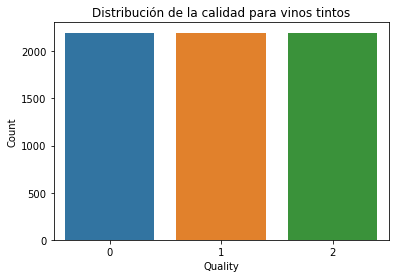

In [403]:
# Distribución de la calidad
plt.figure(figsize=(6, 4))
sns.countplot(x='quality_label', data=oversampled_whitewine_df)
plt.title("Distribución de la calidad para vinos blancos")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

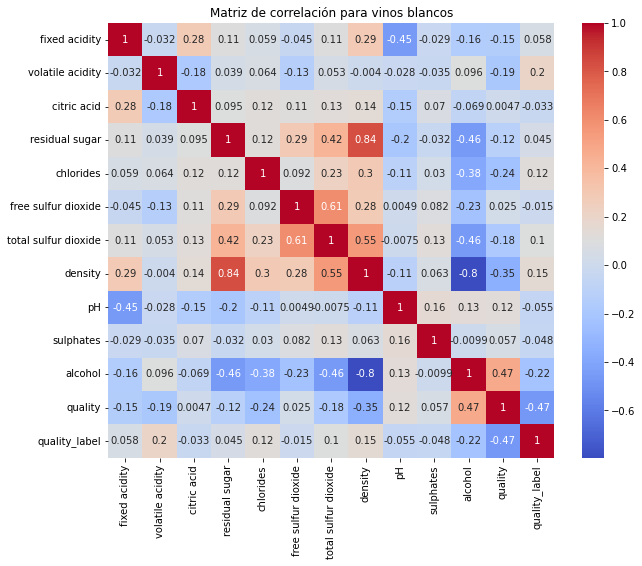

In [420]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
correlation_red = oversampled_whitewine_df.corr()
sns.heatmap(correlation_red, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación para vinos blancos")
plt.show()

### Entrenamiento de los modelos de clasificación

In [405]:
X_white = oversampled_whitewine_df.drop(['quality', 'quality_label'], axis=1)
Y_white = oversampled_whitewine_df['quality_label']

In [406]:
X_white_train, X_white_test, y_white_train, y_white_test = train_test_split(X_white, Y_white, test_size=0.2, random_state=42)

In [416]:
whitewine_svm = SVC(kernel='linear',verbose=False)
whitewine_tree = DecisionTreeClassifier()
whitewine_forest = RandomForestClassifier()

In [417]:
for model, name in zip([whitewine_svm,whitewine_tree, whitewine_forest], ['SVC', 'Decision Tree', 'Random Forest']):
    for wine, X_train, X_test, Y_train, Y_test in zip(['White Wine'], [ X_white_train], [X_white_test], 
                                                       [y_white_train], 
                                                       [y_white_test]):
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        confusion = confusion_matrix(Y_test, predictions)
        scores = cross_val_score(model, X_test, Y_test, cv=10)
        print(f'{name} model average accuracy on {wine}: {scores.mean()}')
        print(f'Matriz de confusión para {name} en {wine}:\n{confusion}\n')

SVR model average accuracy on White Wine: 0.5564307194078186
Matriz de confusión para SVR en White Wine:
[[140 167 156]
 [ 73 319  50]
 [ 81  30 303]]

Decision Tree model average accuracy on White Wine: 0.5882778163312514
Matriz de confusión para Decision Tree en White Wine:
[[315  65  83]
 [ 20 415   7]
 [ 45   9 360]]

Random Forest model average accuracy on White Wine: 0.6633645616470043
Matriz de confusión para Random Forest en White Wine:
[[346  58  59]
 [ 17 423   2]
 [ 40   1 373]]



En este caso se observan 2 niveles de profundidad para el arbol de decisión que clasifica los vinos blancos.

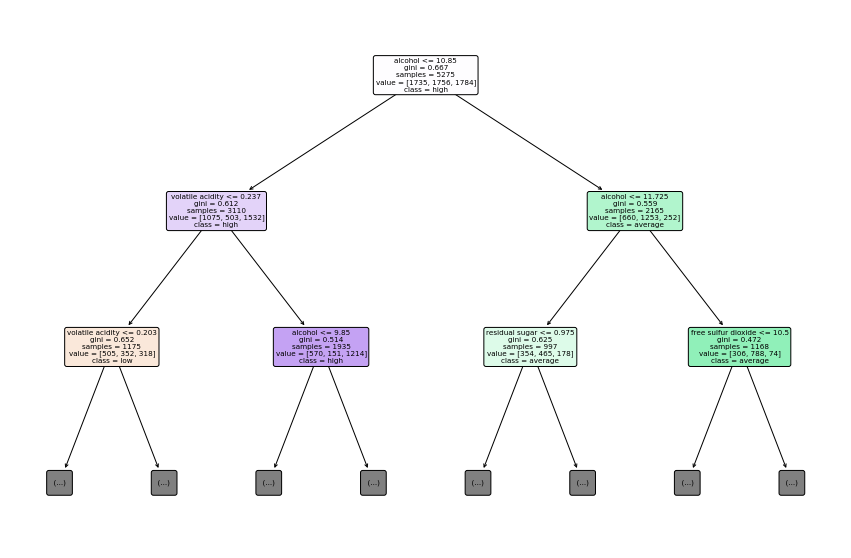

In [434]:
plt.figure(figsize=(15,10))
plot_tree(whitewine_tree, 
          filled=True, 
          rounded=True, 
          feature_names=X_white.columns, 
          class_names=['low', 'average', 'high'],
          max_depth=2)

plt.show()

Se visualiza uno de los árboles generados por RandomForest. Aquí se observan los primeros 2 niveles de profundidad. 

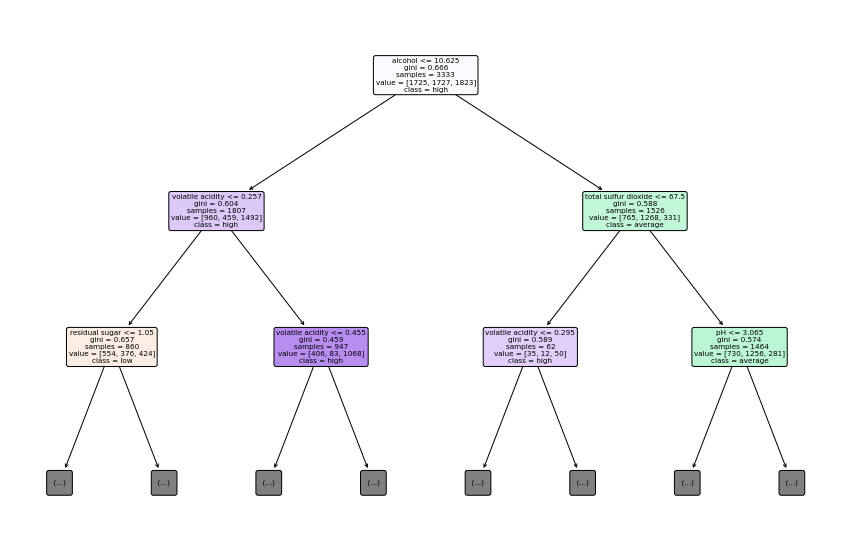

In [435]:
plt.figure(figsize=(15,10))
plot_tree(whitewine_forest.estimators_[0], 
          filled=True, 
          rounded=True, 
          feature_names=X_white.columns, 
          class_names=['low', 'average', 'high'],
          max_depth=2)
plt.show()

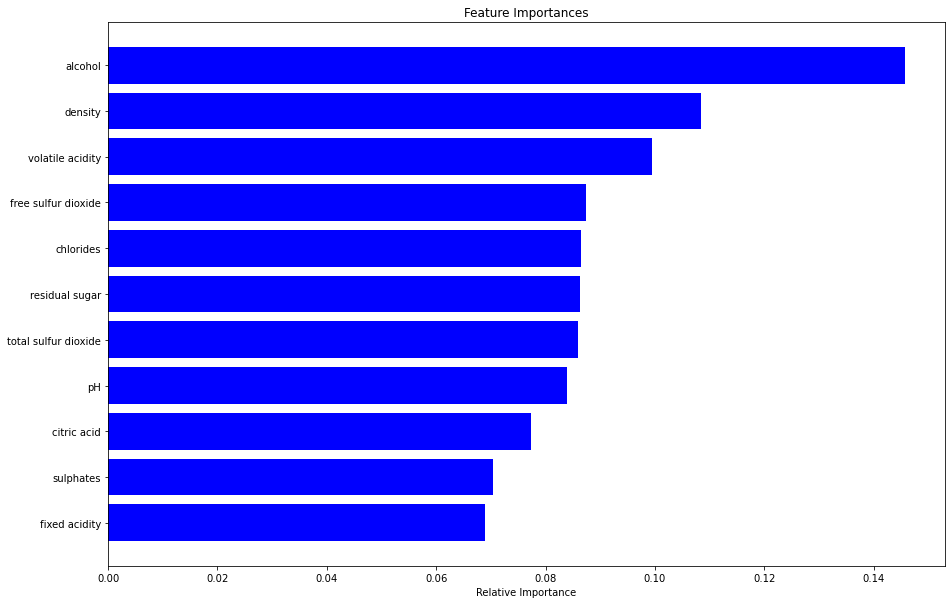

In [436]:
importances = whitewine_forest.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(15,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_white.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()